## Data_Visualization_EIS.ipynb
#### Analyzes EIS Data from Big Kahuna for Convenient Feedback.
##### Miles Smith
##### 19 September 2023

In [1]:
import glob
import os
import math
import statistics
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks, peak_widths
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
# Note that altair was downgraded to v3.0 for impedance.
from impedance.visualization import plot_nyquist, plot_residuals
from impedance.validation import linKK
from sympy import symbols, Eq, solve


###  Notes




### Configure User Inputs

In [2]:
data_name = 'LiTFSI-PEO'
# Set the directory path to where the data files (*.txt) format are located on the computer
directory_path = '/Users/milessmith/Documents/GitHub/mit-tri-robot/data/26Feb2024_LiTFSI-PEO_AN' # Miles MacBook Pro
# directory_path = 'C:\\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data'
# directory_path = 'C:\EIS' # Unchained Labs computer USE THIS DIRECTORY PATH IN 6-020

# Do you want to filter out bad data?
data_filter_selection = 1 # 1 = yes / 0 = no
# If yes, I use the expected value of the residuals compared to a model to determine if the data is adequate.
# What should the threshold be to flag data?
avg_residuals_cutoff = 0.05
# avg_residuals_cutoff = math.inf

# Cell Configuraton
diameter = 0.00803 # [m] Electrode diameter
thickness = 0.00006370833333 #average thickness (might work for now?)
thickness = 80/10**6
# Select equivalent circuit model
user_circuit = 'R0-p(R2-Wo1,C2)'
# Initial guess of parameter values for ECM. From my observations this is a bit finnicky. 
user_guess = [10**4, 10**5, 10**5, 10**-1, 10**-10]

# Do you want multiple plots or each data array to be overlapped on each other?
overlay_data = 1  # 1 = yes | 0 = no

# Do you want a Nyquist diagram for each test?
create_nyquist = 0 # 1 = yes | 0 = no

# Do you want a Bode diagram? 
create_bode = 1 # 1 = yes | 0 = no
# Do you want to save the Bode plot?
save_bode_fig = 1 # 1 = yes. | 0 = no

# Do you want to save the main nyquist diagram generated?
save_main_fig = 1 # 1 = yes | 0 = no
save_figs = 1

concentration_map = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13, 14, 15], 
    [0.75, 0.75, 0.75, 1.50, 1.50, 1.50, 2.25, 2.25, 2.25, 3.00, 3.00, 3.00, 3.75, 3.75, 3.75]
]

# What folder should the figure be saved to?
save_path = '/Users/milessmith/Documents/GitHub/mit-tri-robot/figures' # Miles MacBook Pro
# save_path = r'C:\\Users\miles\Documents\GitHub\mit-tri-robot\figures' # Miles' Windows computer
# save_path = r'C:\\Users\Unchained Labs\Documents\GitHub\mit-tri-robot\figures' # 6-020 computer

# Spreadsheet Path
spreadsheet_path = '/Users/milessmith/Documents/GitHub/mit-tri-robot/eis_dataset.xlsx'

### Select Data files

In [3]:
'''
Example File structure: 103965_5_20230918_073125_25.txt
Plate Number: 103965
Electrode Number (?): 5
Date: 20230918
Electrode Code (?): 073125
Temperature (degC): 25
'''

### NOTICE: The underscores are an important aspect of the strings for temp and electrode number. ###
plate_number1 = '104411_'
# plate_number1 = "skip"

# vial_number = '_13_' # YOU CAN FILTER BY ELECTRODE NUMBER
vial_number = "skip"

# NOTE: Some of the dates are incorrect, so it might be good to configure the code to look at two dates. 
# date1 = '_20231002_' # PICK THE DATE OF THE SAMPLE YOU ARE INTERESTED
date1 = "skip"


temperature = '_25' # YOU CAN FILTER BY TEMPERATURE
# temperature = "skip"

### Frequency Range

The text (.txt) does not include the frequency, so I am manually importing this from a .mpt file. 
If we adjust the frequency range, then we will need to adjust this, but from my observations we always sample
using the same frequencies. This could be subject to change if we ever changed the scan rate, so it is
important to be mindful!

FYI: This specific frequency array probably only works as long as we are using a scan frequency of 0.2. 

In [4]:
# Note: Freq[Hz]
frequency = [ 6999984, 5969734, 5091109, 4341796, 3702781, 3157797, 2693047, 2296687, 1958656,1670375,
             1424531,1214875,1036062,883578.100000000,753531.200000000,642624.900000000,548046.800000000, 
             467390.600000000, 398593.700000000, 339937.500000000, 289906.200000000, 247234.400000000, 
             210843.700000000, 179812.500000000, 153343.800000000, 130781.200000000, 111531.300000000,  
             95109.3700000000, 81109.3700000000, 69171.8800000000, 59000, 50312.5000000000, 42906.2500000000, 
             36593.7500000000, 31203.1300000000, 26609.3800000000, 22703.1300000000, 19359.3700000000,  
             16500, 14112.0200000000, 12011.1300000000, 10236.3800000000, 8750.68400000000, 7449.46300000000, 
             6363.20600000000, 5414.76100000000, 4620.56700000000, 3941.21500000000, 3361.76900000000, 
             2867.24400000000, 2442.65800000000, 2083.00300000000, 1777.84300000000, 1513.54800000000, 
             1292.06500000000, 1101.76200000000, 939.101000000000, 801.280100000000, 684.343300000000, 
             582.947600000000, 497.067700000000, 423.508900000000, 361.503600000000, 308.126200000000, 
             262.729800000000, 224.211100000000, 191.285400000000, 163.172200000000, 139.153700000000, 
             118.670600000000, 101.198200000000, 86.2419600000000, 73.6102400000000, 62.6929100000000, 
             53.5769700000000, 45.6574600000000, 38.9651200000000, 33.1841400000000, 28.3061700000000, 
             24.1723700000000, 20.6134500000000, 17.5561800000000, 14.9855800000000, 12.7655300000000, 
             10.8809000000000, 9.27850500000000, 7.92339400000000, 6.75822000000000, 5.76142900000000, 
             4.91970800000000, 4.19125700000000, 3.56409700000000, 3.05175800000000, 2.60416400000000, 
             2.21442400000000, 1.89256700000000, 1.60750700000000, 1.37641300000000, 1.17375000000000, 
             1.00160400000000 ]

for i in range(len(frequency)):
    frequency[i] = np.int32(frequency[i])

f = np.array(frequency)

### Helper Functions

In [5]:
def ellipse(x, h, k, a, b):
    y = np.zeros(len(x))
    for i in range(len(x)):
        temp = np.sqrt(a**2 * (1 - ((x[i] - h) ** 2) / (a ** 2))) + k
        if temp >= 0:
            y[i] = temp
        else:
            y[i] = math.inf
    return y

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def read_excel_file(file_path):
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active

    # Assuming data is in a simple 2D range
    data = []
    for row in sheet.iter_rows(values_only=True):
        data.append(row)

    workbook.close()
    return data

def write_excel_file(file_path, data):
    workbook = openpyxl.Workbook()
    sheet = workbook.active

    # Write data to the sheet
    for row in data:
        sheet.append(row)

    # Save the workbook
    workbook.save(file_path)
    workbook.close()
    
def row_exists(data, new_row):
    # Check if the new row already exists in the sheet
    for row in sheet:
        if row == new_row:
            return True
    return False

In [6]:
class eis_data:
    
    def __init__(self):
        self.name = []
        self.plate_number = []
        self.sample_number = []
        self.date_characterized = []
        self.concentration = []
        self.temperature = []
        self.spectra_f = []
        self.complex_Z = []
        self.linKK_Z = []
        self.local_minima = []
        self.Z_magnitude = []
        self.Z_phase = []
        self.circle_fit_z_real = []
        self.circle_fit_z_estimated = []
        self.conductance = []
        

### Downsize dataset to only the files of interest

In [7]:
### Read in all file names in EIS folder ###

# Specify the directory path and file extension pattern
extension_pattern = '*.txt'  # List .txt files, for example

# Get a list of file names matching the pattern in the directory
path_names = glob.glob(os.path.join(directory_path, extension_pattern))

# New list to append the files of interest
useful_path = []
for path in path_names:
    if (date1 in path) or (date1 == "skip"):
        if (vial_number in path) or (vial_number == "skip"):
            if (temperature in path) or (temperature == "skip"):
                # I should split this line up!
                if (plate_number1 in path):
                    useful_path.append(path)

print("Number of files selected: " + str(len(useful_path)))

Number of files selected: 15


#### Import each file of data. Quantify the quality of the data. 

In [8]:
data_fail = 0
data_pass = 0

eis = eis_data()
eis.name = data_name
for path in useful_path:
    
    #Import data
    with open(path,'r') as file:
        # Parse data from file name
        directory, filename = os.path.split(path)
        file_name_without_extension, file_extension = os.path.splitext(filename)
        path_info = file_name_without_extension.split('_')
        
        plate_number = int(path_info[0])
        sample_number = int(path_info[1])
        sample_date = str(path_info[2])
        sample_temp = int(path_info[4])
        
        # Extract data from file
        ReZOhm = []
        ImZOhm = []
        ComplexZOhm = []
                
        for line in file:
            ZOhm_Values = line.split()
            ReZOhm.append(float(ZOhm_Values[0]))
            ImZOhm.append(float(ZOhm_Values[1]))
            ComplexZOhm.append(float(ZOhm_Values[0]) - 1j*float(ZOhm_Values[1]))
        
        
        Z = np.array(ComplexZOhm)
        
        # Create a linear Kronig-Kramers model to fit data
        try:
            M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=.85, max_M=100, fit_type='complex', add_cap=True)
            Re_residuals_avg = statistics.mean(abs(res_real))
            Im_residuals_avg = statistics.mean(abs(res_imag))
            if (data_filter_selection == 1):
                bad_data_threshold = avg_residuals_cutoff
            else:
                bad_data_threshold = math.inf
        except:
            data_fail += 1
            continue
            
        # Use linKK to identify which datasets have large residuals and add good data to eis object
        if Re_residuals_avg < bad_data_threshold or Im_residuals_avg < bad_data_threshold:
            
            eis_local_min, _ = find_peaks(Z_linKK.imag, prominence = 1)
            if len(eis_local_min) > 0:
                data_pass += 1

                concentration_idx = concentration_map[0].index(sample_number)
                eis.concentration.append(concentration_map[1][concentration_idx])
                eis.plate_number.append(plate_number)
                eis.sample_number.append(sample_number)
                eis.date_characterized.append(sample_date)
                eis.temperature.append(sample_temp)
                eis.spectra_f = f
                eis.complex_Z.append(Z)
                eis.linKK_Z.append(Z_linKK)
                eis.local_minima.append(eis_local_min)

        else:
            data_fail += 1
            continue

print(data_fail)

10 0.9995552383197116 36107.06583025362
10 0.9373974942446578 2716462.681392821
10 0.9999061478364473 53848.1026938234
10 0.882203445609173 12035460.336268794
10 0.8773010038311446 3869632.0041504926
10 0.9996353146697268 92943.7418923369
10 0.969903791579103 39290.54093138943
10 0.9830410614613145 141725.4208747245
10 0.974263249249216 227996.96207748624
10 0.9999789814585 89270.99878536606
10


/Users/milessmith/anaconda3/envs/conda-env/lib/python3.11/site-packages/impedance/validation.py:306: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - neg_sum/pos_sum


#### Calculate magnitude and phase for Bode diagram

In [9]:
for i in range(len(eis.sample_number)):
    # Bode Diagram
    ZOhm = []
    ZVector = []
    ZPhase = []

    for j in range(len(eis.complex_Z[i])):
        ReZOhm = eis.complex_Z[i][j].real
        ImZOhm = eis.complex_Z[i][j].imag
        ZVector.append(math.sqrt(ReZOhm**2+ImZOhm**2))
        ZPhase.append(math.atan(ImZOhm/ReZOhm)*180/math.pi) # Phase in degrees = atan(Im|Z|/Re|Z|)
    
    eis.Z_magnitude.append(ZVector)
    eis.Z_phase.append(ZPhase)

#### Make Bode and Nyquist Diagrams

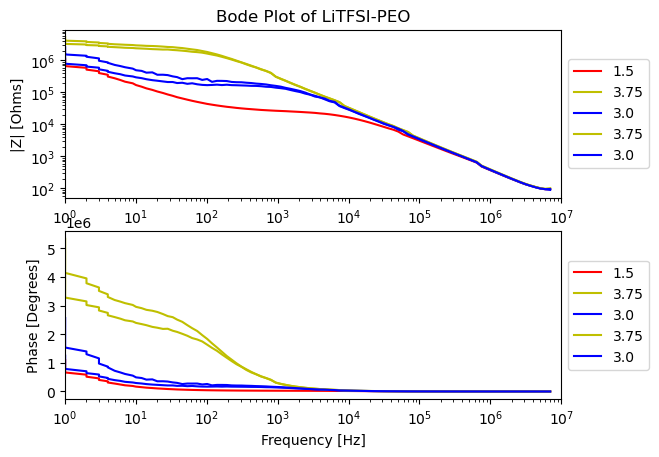

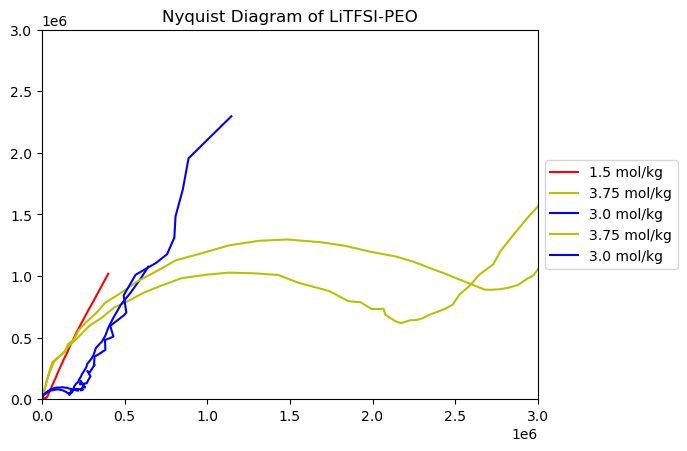

In [16]:
bode_fig, bode_ax = plt.subplots(2)
nyquist_fig, nyquist_ax = plt.subplots(1)
                                 
for i in range(len(eis.sample_number)):
    sample_label = (str(eis.plate_number[i]) + '-' + str(eis.sample_number[i]) + ' | ' + str(eis.temperature[i]) + 'degC')
    

    
    concs = [0.75, 1.50, 2.25, 3.00, 3.75]
    cmap = ['c', 'r', 'g', 'b','y']
    conc_idx = concs.index(eis.concentration[i])
    color = cmap[conc_idx]
    
    bode_ax[0].loglog(eis.spectra_f, eis.Z_magnitude[i], c = color, label = eis.concentration[i])
    bode_ax[1].semilogx(eis.spectra_f, eis.Z_magnitude[i], c = color, label = eis.concentration[i])
    
    nyquist_ax.plot(eis.complex_Z[i].real, -eis.complex_Z[i].imag, c = color, label= str(eis.concentration[i]) + ' mol/kg')
    
nyquist_ax.set_xlim([0, 3000000])
nyquist_ax.set_ylim([0, 3000000])
nyquist_ax.set_title('Nyquist Diagram of ' + eis.name) # + ' at ' + str((eis.concentration[0])) + ' mol/kg' )
nyquist_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

bode_ax[0].set_title('Bode Plot of ' + eis.name)
bode_ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
bode_ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
bode_ax[1].set_xlabel('Frequency [Hz]')
bode_ax[0].set_ylabel('|Z| [Ohms]')
bode_ax[1].set_ylabel('Phase [Degrees]')
bode_ax[0].set_xlim([1, 10**7])
bode_ax[1].set_xlim([1, 10**7])

if save_figs == 1:
    bode_fig.savefig(save_path + '/' + str(eis.date_characterized[0]) + eis.name + '_bode.png', bbox_inches='tight')
    nyquist_fig.savefig(save_path + '/' + str(eis.date_characterized[0]) + eis.name + '_nyquist_' + str(eis.concentration[0]) + '.png', bbox_inches='tight')


#### Calculate conductance from Nyquist diagram

In [51]:
for i in range(len(eis.sample_number)):
    z = eis.complex_Z[i][0:eis.local_minima[i][-1]]    
    h0 = max(z.real)/2 # Center position x
    k0 = 0
    a0 = max(z.real)/2 # x radius
    b0 = max(z.real)/2 # y radius
    p0 = (h0, k0, a0, b0)  # Initial guesses for parameters
    
    
    try:
        optimized_params, _ = curve_fit(ellipse, z.real, -z.imag, p0=p0)

        hf = optimized_params[0]
        kf = optimized_params[1]
        af = optimized_params[2]
        bf = optimized_params[3]

        # Define variables
        x = symbols('x')
        # Equation of the semi-circle
        equation = Eq(((x - hf)**2) / (af**2) + (kf**2) / (bf**2), 1)

        # Solve for x
        roots = solve(equation, x)
        conductance = 1/abs(roots[1] - roots[0])

        z_imag_circle = ellipse(z.real,h0,k0,a0,b0)

        eis.conductance.append(conductance)
        eis.circle_fit_z_real.append(z.real)
        eis.circle_fit_z_estimated.append(z_imag_circle)
    except:
        conductance = 0 
        eis.conductance.append(conductance)
        eis.circle_fit_z_real.append([0])
        eis.circle_fit_z_estimated.append([0])

/var/folders/hx/mzdy_0px4vjdf00n9svk8mfw0000gn/T/ipykernel_72850/712724750.py:4: RuntimeWarning: invalid value encountered in sqrt
  temp = np.sqrt(a**2 * (1 - ((x[i] - h) ** 2) / (a ** 2))) + k


#### Fit equivalent circuit model, generate each Nyquist diagram

* Note that the ECM fitting is not working well. How can we pick the initial guess effectively?

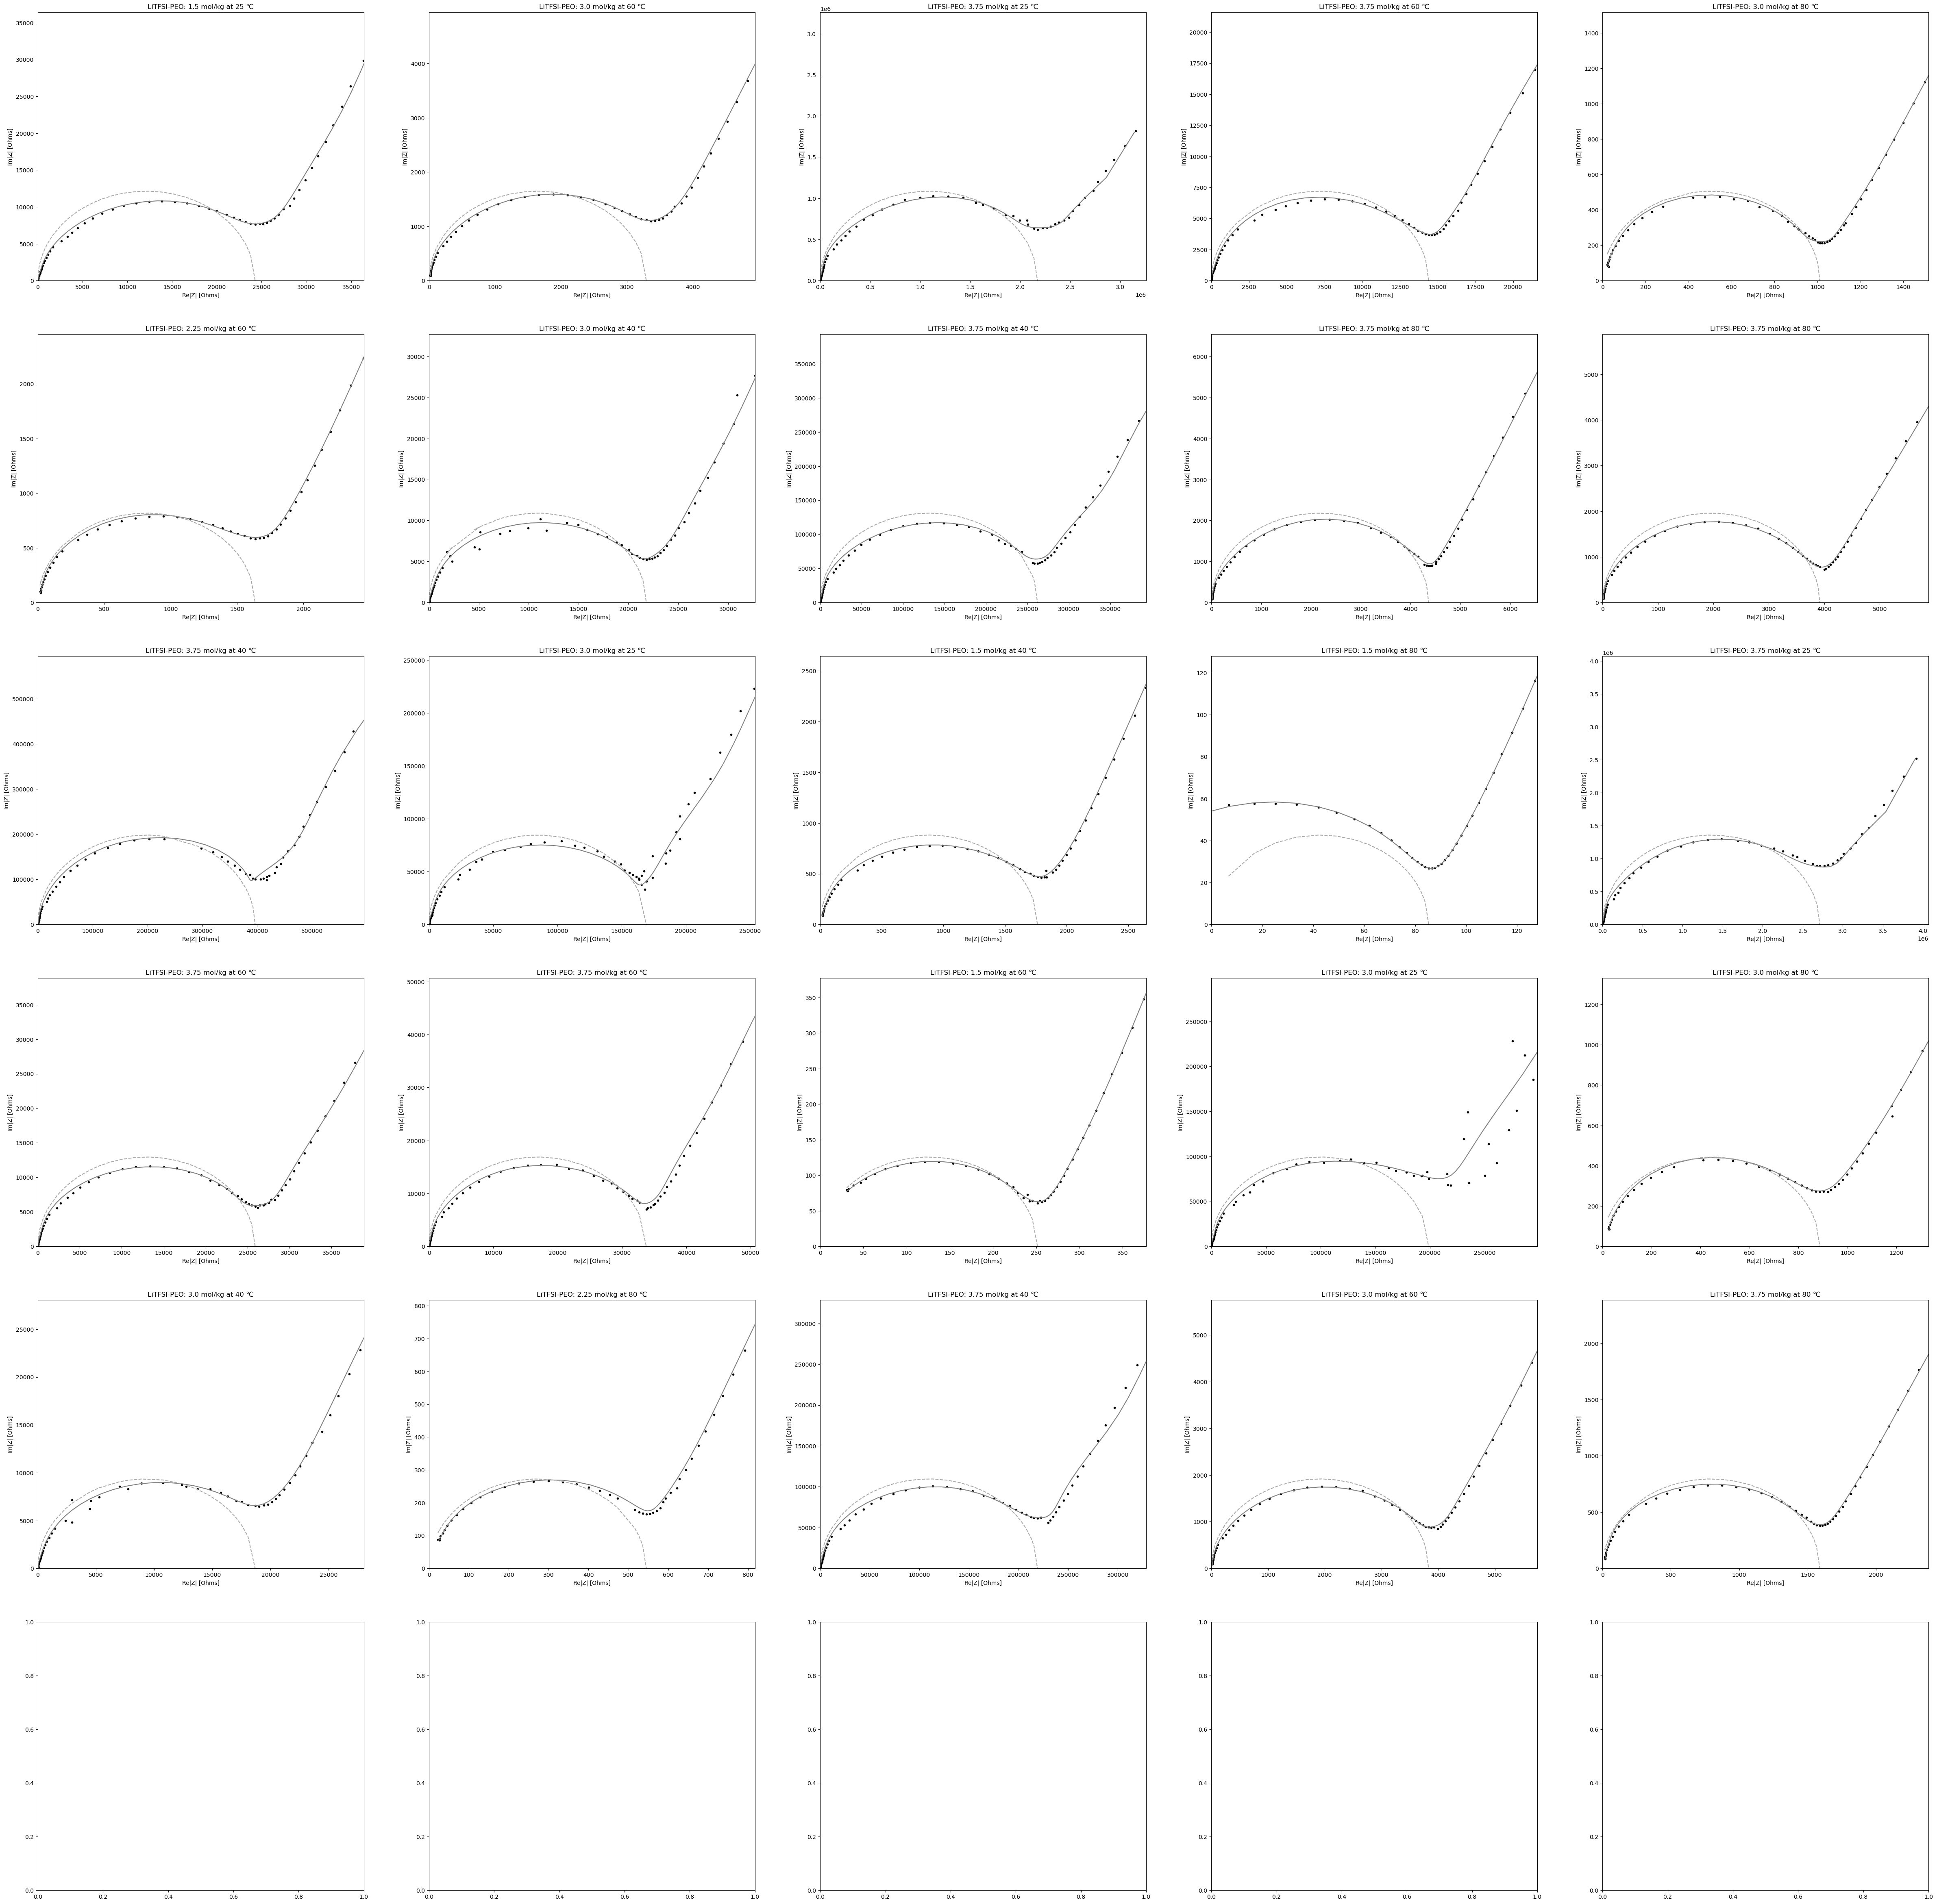

In [52]:
circuit = user_circuit
# Initial guess of parameter values for ECM. From my observations this is a bit finnicky. 
p0 = [10**0, 10**4, 10**6, 10**-7, 10**-7]

circuit = CustomCircuit(circuit, initial_guess=p0)
# Fit data to equivalent circuit model
fig_cols = 5

ecm_fig, ecm_ax = plt.subplots(int(len(eis.sample_number)/fig_cols)+1, ncols=fig_cols)

for i in range(len(eis.sample_number)):

    circuit.fit(eis.spectra_f, eis.complex_Z[i])
    Z_fit = circuit.predict(eis.spectra_f)

    ecm_ax[int(i/fig_cols)][i%fig_cols].plot(eis.complex_Z[i].real, -eis.complex_Z[i].imag, '.', markersize=6, color='black')
    #ecm_ax[int(i/fig_cols)][i%fig_cols].plot(Z_fit.real, -Z_fit.imag, '--',color='black',alpha=0.6)
    ecm_ax[int(i/fig_cols)][i%fig_cols].plot(eis.linKK_Z[i].real, -eis.linKK_Z[i].imag,'-',color='gray')
    ecm_ax[int(i/fig_cols)][i%fig_cols].plot(eis.circle_fit_z_real[i], eis.circle_fit_z_estimated[i],'--',color='darkgray')
    ecm_ax[int(i/fig_cols)][i%fig_cols].set_xlabel('Re|Z| [Ohms]')
    ecm_ax[int(i/fig_cols)][i%fig_cols].set_ylabel('Im|Z| [Ohms]')
    ecm_ax[int(i/fig_cols)][i%fig_cols].set_title(eis.name + ': ' + str(eis.concentration[i]) + ' mol/kg at ' + str(eis.temperature[i]) + ' ℃')
    ecm_ax[int(i/fig_cols)][i%fig_cols].set_xlim([0, max(eis.circle_fit_z_real[i])*1.5])
    ecm_ax[int(i/fig_cols)][i%fig_cols].set_ylim([0, max(eis.circle_fit_z_real[i])*1.5])
    ecm_fig.set_figheight(int(len(eis.sample_number)/fig_cols)*12)
    ecm_fig.set_figwidth(fig_cols*12)

if save_figs == 1:
    ecm_fig.savefig(save_path + '/' + str(eis.date_characterized[i]) + '_' + eis.name + '_'+ str(min(eis.concentration)) +'_'+ str(max(eis.concentration)) + '_m' +'_nyquist.png', bbox_inches='tight', dpi=100)

#### Conductance - Concentration and Conductance - Temperature Diagrams

IndexError: list index out of range

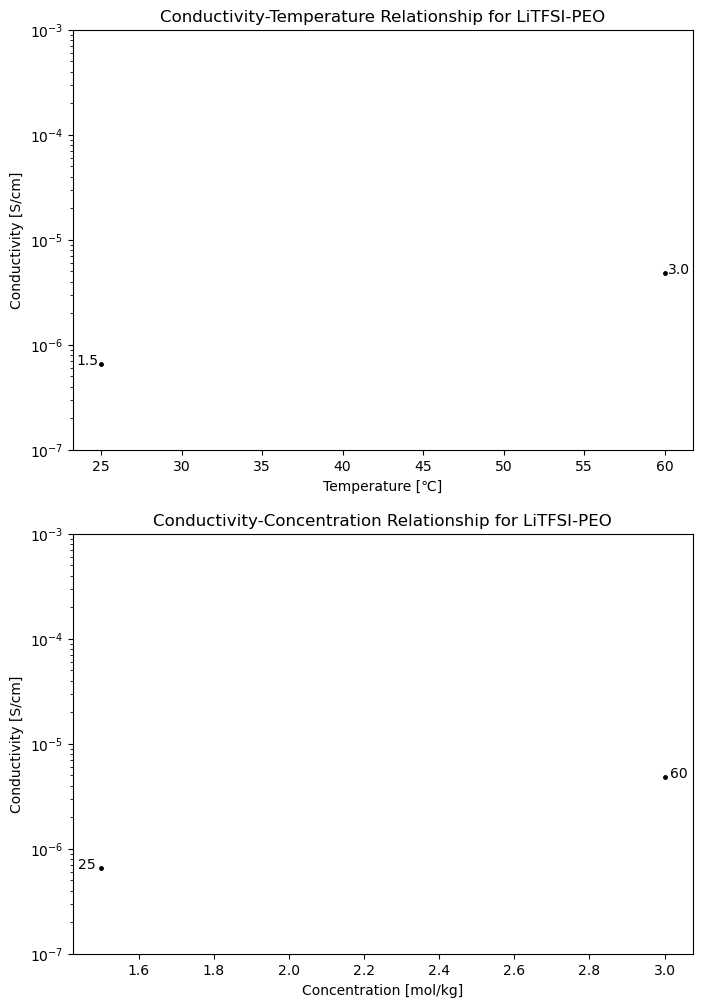

In [53]:
conductance_fig, conductance_ax = plt.subplots(2)
area = math.pi*diameter**2/4

color_array = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
marker_array = ['o','*','.',',', 'x','X','P','s','D','d','p','H','h','v','^','<','>','1','2','3','4','|','_']


for i in range(len(eis.sample_number)):
    
    if i % 2 == 1:
        label_direction = 1
    else:
        label_direction = -1
        
    if eis.sample_number[i] > len(color_array):
        shift = 1
    else:
        shift = 0
    
    color_idx = eis.sample_number[i]%len(color_array)
    sample_color = color_array[eis.sample_number[i]%len(color_array) + shift]
    sample_marker = marker_array[eis.sample_number[i]]
    temp_color = color_array[int(eis.temperature[i]/10-2)]
    
    conductivity = eis.conductance[i]/area*thickness/100
    conductance_ax[0].semilogy(eis.temperature[i], conductivity,marker='.', markersize='5', color='black', label=eis.concentration[i])
    conductance_ax[0].annotate(eis.concentration[i],
                               (eis.temperature[i], conductivity),
                               textcoords="offset points",
                               xytext=(label_direction*10,0),
                               ha='center')
    conductance_ax[0].set_xlabel('Temperature [℃]')
    conductance_ax[0].set_ylabel('Conductivity [S/cm]')
    conductance_ax[0].set_title('Conductivity-Temperature Relationship for ' + data_name)
    conductance_ax[1].semilogy(eis.concentration[i], conductivity,marker='.', markersize='5', color='black', label=eis.sample_number[i])
    conductance_ax[1].annotate(eis.temperature[i],
                               (eis.concentration[i], conductivity),
                               textcoords="offset points",
                               xytext=(label_direction*10,0),
                               ha='center')
    conductance_ax[1].set_title('Conductivity-Concentration Relationship for ' + data_name)
    conductance_ax[1].set_ylabel('Conductivity [S/cm]')
    conductance_ax[1].set_xlabel('Concentration [mol/kg]')
    conductance_ax[1].set_ylim([10**-7, 10**-3])
    conductance_ax[0].set_ylim([10**-7, 10**-3])


    conductance_fig.set_figheight(12)
    conductance_fig.set_figwidth(8)
    
if save_figs == 1:
    conductance_fig.savefig(save_path + '/' +  str(eis.date_characterized[i]) + '_' +eis.name + '_'+ str(min(eis.concentration)) +'_'+ str(max(eis.concentration)) + '_m' + '_conductivity.png', bbox_inches='tight',dpi=600)

#### Save to Dataset

In [55]:
data = []

existing_data = read_excel_file(spreadsheet_path)
print('------- Original Data -------')
for row in existing_data:
    data.append(row)
    print(row)
    
print('------- New Data -------')

for i in range(len(eis.sample_number)):
    
    new_row = [int(eis.date_characterized[i]), eis.name, int(eis.sample_number[i]), eis.concentration[i], int(eis.plate_number[i]), int(eis.temperature[i]), float(eis.conductance[i]*thickness/area/100)]  
    # Figure out how to only add new data to the dataset. 
    data.append(new_row)
    print(new_row)
    
save_data_prompt = int(input('Would you live to save this data?'))
if save_data_prompt == 1:    
    write_excel_file(spreadsheet_path, data)
    print('Data saved')
else:
    print('Data not saved.')

------- Original Data -------
('Date', 'Name', 'Sample Number', 'Concentration (mol/kg)', 'Plate Number', 'Temperature (℃)', 'Conductivity (S/cm)')
(20231114, 'LiClO4-PEO', 13, 3, 104150, 60, 9.301293084766625e-06)
(20231113, 'LiClO4-PEO', 4, 1.5, 104150, 60, 5.523390064497715e-05)
(20231113, 'LiClO4-PEO', 4, 1.5, 104150, 70, 7.42388051941247e-05)
(20231114, 'LiClO4-PEO', 13, 3, 104150, 70, 2.011490425361849e-05)
(20231113, 'LiClO4-PEO', 9, 2.25, 104150, 70, 5.062855941656531e-05)
(20231113, 'LiClO4-PEO', 1, 1.5, 104150, 60, 6.109907186491372e-05)
(20231113, 'LiClO4-PEO', 8, 2.25, 104150, 70, 6.235258455861915e-05)
(20231113, 'LiClO4-PEO', 8, 2.25, 104150, 60, 3.369567523329165e-05)
(20231113, 'LiClO4-PEO', 9, 2.25, 104150, 60, 2.781028381761755e-05)
(20231113, 'LiClO4-PEO', 1, 1.5, 104150, 70, 7.84488896027997e-05)
(20231113, 'LiClO4-PEO', 1, 1.5, 104150, 40, 1.535356621963333e-06)
(20231113, 'LiClO4-PEO', 9, 2.25, 104150, 50, 1.286585737964082e-05)
(20231113, 'LiClO4-PEO', 8, 2.25, 1

Would you live to save this data? 1


Data saved


### Data Import, Basic Analysis, and Figures
Here I imported the data from the system and did basic calculations for further analysis.


In [ ]:
'''
Open and manage data from .txt files
'''
    
bad_data = 0
good_data = 0

bode_fig, bode_ax = plt.subplots(2)


for path in useful_path:
    
    # Open the file for reading
    with open(path, 'r') as file:
        
        # Extract sample information
        # Split the path into directory and filename
        directory, filename = os.path.split(path)
        # Extract the file name without the extension
        file_name_without_extension, file_extension = os.path.splitext(filename)
        path_info = file_name_without_extension.split('_')
        # Parse into useful variables
        plate_str = path_info[0]
        vial_str = path_info[1]
        date_str = path_info[2]
        vial_id_str = path_info[3]
        temp_str = path_info[4]
        
        '''
        conc_str = '0'
        if int(vial_str) == 1:
            conc_str = '0.2'
        elif int(vial_str) == 4:
            conc_str = '1'
        elif int(vial_str) == 8:
            conc_str = '2'
        elif int(vial_str) == 13:
            conc_str = '3.75'
        '''
        
        path_id = "Sample: " + plate_str + "-" + vial_str + " | Temp: " + temp_str + " degC"
        # conc_id = conc_str + " mol  at " + temp_str + "degC"
        
        # Initialize arrays for impedance and conductivity values.
        ReZOhm = []
        ImZOhm = []
        conductivity = []
        i = 0

        area = math.pi*diameter**2/4
                
        # Parse each line in the .txt files to the correct array.
        for line in file:
            ZOhm_Values = line.split()
            ReZOhm.append(float(ZOhm_Values[0]))
            ImZOhm.append(float(ZOhm_Values[1]))
            i += 1
        
        # Bode Diagram
        ZOhm = []
        ZVector = []
        ZPhase = []
        
        for i in range(len(ReZOhm)):
            Z_temp = ReZOhm[i] - 1j*ImZOhm[i] # Rearrange into format of array. 
            ZOhm.append(Z_temp)
            ZVector.append(math.sqrt(ReZOhm[i]**2+ImZOhm[i]**2))
            ZPhase.append(math.atan(ImZOhm[i]/ReZOhm[i])*180/math.pi) # Phase in degrees = atan(Im|Z|/Re|Z|)
            
        Z = np.array(ZOhm)
                
        f_KK = f
        Z_KK = Z
        
        # Create a linear Kronig-Kramers model to fit data
        try:
            M, mu, Z_linKK, res_real, res_imag = linKK(f_KK, Z_KK, c=.85, max_M=100, fit_type='complex', add_cap=True)
            Re_residuals_avg = statistics.mean(abs(res_real))
            Im_residuals_avg = statistics.mean(abs(res_imag))
            if (data_filter_selection == 1):
                bad_data_threshold = avg_residuals_cutoff
            else:
                bad_data_threshold = math.inf
        except:
            print("[XX] Data type and structure error in: ", file.name)
            bad_data += 1
            continue
            
        # Use linKK to identify which datasets have large residuals. 
        if Re_residuals_avg < bad_data_threshold or Im_residuals_avg < bad_data_threshold:
            # print("[!!] Residuals are good in: ", file.name)
            good_data += 1
            Z = ZOhm

        else:
            # print("[XX] High residuals in: ", file.name)
            bad_data += 1
            continue
        
        if len(Z) == len(f):
            dZ = np.zeros(len(res_imag))
            critical_points = []
            prev_median = 1
            for i in range(len(res_imag)):
                if i > 0:
                    dZ[i] = -(res_imag[i]-res_imag[i-1])
                    buff_size = 10
                    if i > buff_size:
                        temp_buf = []
                        for j in range(buff_size):
                            temp_buf.append(dZ[i-j])
                        temp_median = statistics.median(temp_buf)
                        if (temp_median > 0) and (prev_median < 0):
                            critical_points.append(i)
                        prev_median = temp_median
            
            print(critical_points)
            erroneous_critical_point_index = 40
            if critical_points[0] > erroneous_critical_point_index or len(critical_points) == 1:
                Z_circle = Z_linKK[1:critical_points[0]]
            else:
                Z_circle = Z_linKK[1:critical_points[1]-15]
        
        # Fit to an ellipse.. How shall we generalize?
        h0 = max(Z_circle.real)/2 # Center position x
        print("h0 2: " + str(h0))
        k0 = 0
        a0 = max(Z_circle.real)/2 # x radius
        b0 = max(Z_circle.real)/2 # y radius

        p0 = (h0, k0, a0, b0)  # Initial guesses for parameters

        try:
            optimized_params, _ = curve_fit(ellipse, Z_circle.real, -Z_circle.imag, p0=p0, method='dogbox')
            Re_Z_range = np.linspace(0, max(Z_circle.real)*1.5, 100)
            Im_Z_fit = ellipse(Re_Z_range, *optimized_params)
            # print("[!!] Vial: " + vial_str + " Temp: " + temp_str + " | Parameters converged")
            # conductivity_val = (1/Z_high[0])*length/area
            conductivity_val = (1/(2*optimized_params[2]))*length/area
            print("Conductivity: " + str(conductivity_val) + " S/m")
            conductivity_array = [vial_str, temp_str, conductivity_val]
            print(conductivity_array)
        except:
            print("Convergence Failed")
            Re_Z_range = np.linspace(0, max(Z_circle.real)*1.5, 100)
            Im_Z_fit = ellipse(Re_Z_range, *p0)
            conductivity_val = (1/(2*p0[2]))*length/area
            print("Conductivity: " + str(conductivity_val) + " S/m")
            conductivity_array = [vial_str, temp_str, conductivity_val]
            print(conductivity_array)
            
        figure_lim = max(Z_circle.real)*1.2

        Z_poly = []
        for i in range(len(Re_Z_range)):
            Z_temp = Re_Z_range[i] - 1j*Im_Z_fit[i]
            Z_poly.append(Z_temp)

        Z_low = Z_poly[0].real
        Z_high = Re_Z_range[np.where(Im_Z_fit == min(Im_Z_fit))]

        if (save_main_fig == 1):
            pass
        else:
            circuit = user_circuit
            # Initial guess of parameter values for ECM. From my observations this is a bit finnicky. 
            initial_guess = user_guess
            circuit = CustomCircuit(circuit, initial_guess=initial_guess)
            # Fit data to equivalent circuit model
            circuit.fit(f, Z)
            Z_fit = circuit.predict(f)
            
            if create_nyquist == 1:
                # Create Nyquist Plot
                plt.figure(4)
                modelFig, ax = plt.subplots()
                # plot_nyquist(Z_poly, fmt = '--', scale = 1, ax = ax)
                plot_nyquist(Z, fmt='o', scale=1, ax=ax)
                plot_nyquist(Z_fit, fmt='-', scale=1, ax=ax)
                plot_nyquist(Z_linKK, fmt='-', scale=1, ax=ax)
                plt.legend(['Fitted Circle', path_id, 'Circuit Model', 'Kronig-Kramers Model', 'circle'], loc='center left', bbox_to_anchor=(1, 0.5))
                plt.xlim((0, figure_lim))
                plt.ylim((0, figure_lim))
                modelFig.show()

                # Plot residuals
                plt.figure(5)
                residualFig, ax2 = plt.subplots()
                plot_residuals(ax2, f_KK, res_real, res_imag, y_limits=(-50, 50))
                residualFig.show()


        plt.figure(2)
        #plt.loglog(ReZOhm, ImZOhm, label = path) # I know this is unconventional, but it makes it easier to look at multiple lines.
        plt.plot(ReZOhm, ImZOhm, label = path_id)
        # plt.plot(np.real(Z_linKK), -np.imag(Z_linKK), linestyle = '--', label = path)
        plt.title('LiClO4-PEO Sample from 11/4/2023')
        plt.xlabel('Re|Z|')
        plt.ylabel('Im|Z|')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        nyquist_range = 100000
        plt.xlim((0, nyquist_range))
        plt.ylim((0, nyquist_range))

        
        if create_bode == 1:
            bode_ax[0].set_title('Bode Plot for LiClO4-PEO Sample')
            bode_ax[0].loglog(frequency, ZVector, label = path_id)
            bode_ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            bode_ax[1].semilogx(frequency, ZPhase, label = path_id)
            bode_ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            bode_ax[1].set_xlabel('Frequency [Hz]')
            bode_ax[0].set_ylabel('|Z| [Ohms]')
            bode_ax[1].set_ylabel('Phase [Degrees]')
            '''
            fig, ax1 = plt.subplots()
            plt.title('Bode Plot: Magnitude and Phase as a function of Frequency')
            color = 'tab:blue'
            ax1.set_xlabel('Frequency [Hz]')
            ax1.set_ylabel('Magnitude', color=color)
            ax1.loglog(frequency, ZVector, label = path)
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()
            color = 'tab:red'
            ax2.set_ylabel('Phase', color=color)  # we already handled the x-label with ax1
            ax2.loglog(frequency, ZPhase, color = color)
            ax2.tick_params(axis='y', labelcolor=color)
            '''
        

print("Number of Adequate Data Files: ", good_data, "| Number of Poor Data Files: ", bad_data, "| Total Number of Files: ", good_data+bad_data)

if (save_main_fig == 1):
    # plt.savefig(save_path+'\mainfigure.png') # if Windows
    plt.savefig(save_path+'/mainfigure.png', bbox_inches='tight') # if Mac

if (save_bode_fig == 1):
    bode_fig.savefig(save_path+'/bodefig.png', bbox_inches='tight') # Mac

